# Modelling & Fine Tunning

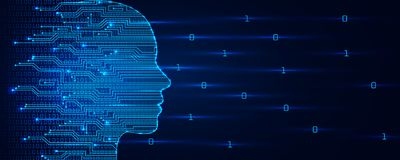

# Objective



*   In this step, we will search for the model and parameters with the best performance for the chosen metrics.



# 1. Library imports

In [ ]:
import math
import numpy as np
import pandas as pd

import inflection
import seaborn as sns
import random
import warnings
from matplotlib import pyplot as plt
from IPython.core.display import HTML
import xgboost as xgb

from scipy import stats as ss
from boruta import BorutaPy
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


#Helper Functions

For this section, some helper functions have been created.

*   **cross_validation**: Through this technique, the data are divided into blocks (Folds) and different training/validation combinations are created with these blocks, in order to reduce the chances of getting only one biased combination and, thus, allowing a greater capacity for generalization to our model




In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed( range( 1, kfold+1 ) ):
    if verbose:
      print( '\nKFold Number: {}'.format( k ) )
    # start and end date for validatio
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
    # training and validation dataset
    # training
    xtraining = training.drop( ['date', 'sales'], axis=1 )
    ytraining = training['sales']
    # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']
    # model
    m = model.fit( xtraining, ytraining )
    # prediction
    yhat = m.predict( xvalidation )
    # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
    # store performance of each kfold iteration
    mae_list.append( m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )
  return pd.DataFrame( {'Model Name': model_name,
  'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
  'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
  'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

def mean_percentage_error( y, yhat ):
  return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
  return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
  mae = mean_absolute_error( y, yhat )
  mape = mean_absolute_percentage_error( y, yhat )
  rmse = np.sqrt( mean_squared_error( y, yhat ) )
  return pd.DataFrame( { 'Model Name': model_name,
  'MAE': mae,
  'MAPE': mape,
  'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).values
  n = cm.sum()
  r, k = cm.shape
  chi2 = ss.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


# 2. Machine Learning Modelling

First, select only the variables determined by botura

In [ ]:

x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

3 metrics were chosen

*   **MAE:** In summary, it represents the difference between predicted and actual value. Assigns equal weight to all errors, so it is considered robust in the presence of outliers
*   **MAPE**: How far is the prediction from the actual value on average in percentage
*   **RMSE:** Used as an improvement metric as it assigns greater weight to larger errors

## 6.1 Average Model

We will use the average model as a basic benchmark in relation to the performance of the initial models.

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance (transformando de volta sales que estava em log)
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 6.2 Linear Regression Model

Firstly, i've tested two linear models to see if the sales phenomena could be modeled linearly.

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )
# prediction
yhat_lr = lr.predict( x_test )
# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

# BY RMSE we can see that the average model performed relatively better. Also, our data has a complex behave - not linear

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


The results relatively inferior to the average model indicate that our prediction can benefit from more robust models

In [ ]:
# Linear Regression Model - Cross Validation

lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 6.3 Linear Regression Regularized Model - Lasso

In [ ]:
# model - alpha fator multiplicativo de cada um dos pesos 
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


Same here...

In [ ]:
#Lasso - Cross Validation
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


##6.4 Random Forest Regressor

In [ ]:
 # model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )
# prediction
yhat_rf = rf.predict( x_test )
# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


Here we already have a better result, which indicates that we are on the right track in capturing the nonlinear behavior of our variables

In [ ]:
#Random Forest Regressor - Cross Validation
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf,verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 6.5 XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=100,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction

yhat_xgb = model_xgb.predict( x_test )
# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112293,0.122609,1250.952637


In [ ]:
# XGBoost Regressor - Cross Validation
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 6.6 Compare Model's Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,843.112293,0.122609,1250.952637
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


Using Time Series Cross-Validation with 5 folds and maintaining the last 6 weeks of data in each fold for validation the results were:

In [ ]:
#Real Performance - Cross Validation

modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


Conclusion: We may see that the sales variable's behavior is too complex for linear models to grasp. A surprise is that simply calculating the mean (arithmetic average) of sales for each month, and using it as a projection, outperformed the linear models. Finally, among all tested models, tree-based ones performed the best. Therefore I decided to use the XGB Random Forest Regressor since it's a very flexible and performing model and it usually occupies less memory than Random Forests.

# 3. Hyperparameter fine tuning

From the tuning we can improve the performance of our model in front of the chosen metrics. In this first moment, I will use a simple random search - in the future we can improve with Bayesian optimization, similar to the pipeline built for previously in the game recommendation engine project

## 3.1 Random Search

In [ ]:
param = {
'n_estimators': [1500, 1700, 2500, 3000, 3500],
'eta': [0.01, 0.03],
'max_depth': [3, 5, 9],
'subsample': [0.1, 0.5, 0.7],
'colsample_bytree': [0.3, 0.7, 0.9],
'min_child_weight': [3, 8, 15]
}

warnings.filterwarnings('ignore')
MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
   # choose values for parameters randomly
  hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
  print( hp )

  # model
  model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
  n_estimators=hp['n_estimators'],
  eta=hp['eta'],
  max_depth=hp['max_depth'],
  subsample=hp['subsample'],
  colsample_bytee=hp['colsample_bytree'],
  min_child_weight=hp['min_child_weight'])

  # performance
  result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,verbose=True )
  final_result = pd.concat( [final_result, result] )

final_result


{'n_estimators': 15, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 35, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 25, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 30, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 35, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Num

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6184.57 +/- 577.29,0.81 +/- 0.01,6911.84 +/- 680.09
0,XGBoost Regressor,2414.44 +/- 353.83,0.29 +/- 0.02,3425.63 +/- 468.73
0,XGBoost Regressor,3671.57 +/- 401.58,0.45 +/- 0.02,4506.24 +/- 511.79
0,XGBoost Regressor,2711.3 +/- 330.24,0.32 +/- 0.02,3576.12 +/- 432.08
0,XGBoost Regressor,2317.24 +/- 322.39,0.28 +/- 0.02,3275.41 +/- 425.95


## 3.2 v1.0 Model

In [ ]:
param_tuned = {
'n_estimators': 3000,
'eta': 0.03,
'max_depth': 5,
'subsample': 0.7,
'colsample_bytree': 0.7,
'min_child_weight': 3
}


In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                      n_estimators=param_tuned['n_estimators'],
                                      eta=param_tuned['eta'],
                                      max_depth=param_tuned['max_depth'],
                                      subsample=param_tuned['subsample'],
                                      colsample_bytee=param_tuned['colsample_bytree'],
                                      min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )


In [ ]:
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974997,0.097529,957.774225


In [ ]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.0035453340418880428